SchNet on Graphcore IPU
=======================
> *Note: PyTorch Geometric support with PopTorch SDK 3.0 is currently experimental.*
> *Please direct any questions or feedback to support@graphcore.ai*


This notebook demonstrates training a [SchNet graph neural network](https://arxiv.org/abs/1712.06113) with PyTorch Geometric on the Graphcore IPU.  We will use the QM9 dataset from the [MoleculeNet: A Benchmark for Molecular
    Machine Learning](https://arxiv.org/abs/1703.00564) paper and train the SchNet model to predict the HOMO-LUMO energy gap.

This notebook assumes some familiarity with PopTorch as well as PyTorch Geometric (PyG).  For additional resources please consult:

* [PopTorch Documentation](https://docs.graphcore.ai/projects/poptorch-user-guide/en/latest/index.html)
* [PopTorch Examples and Tutorials](https://docs.graphcore.ai/en/latest/examples.html#pytorch)
* [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/)

Requirements:

* Paperspace account with access to the PyTorch IPU runtime
* Python packages in `requirements-pyg.txt`, installed below


In [ ]:
%pip install -r requirements-pyg.txt

In [1]:
%matplotlib inline
import os
import os.path as osp

import torch
import poptorch
import pandas as pd
import py3Dmol

from periodictable import elements
from torch_geometric.datasets import QM9
from torch_geometric.data import Batch
from torch_geometric.loader import DataLoader
from torch_geometric.nn import to_fixed_size
from torch_geometric.nn.models import SchNet
from torch_geometric import optional_validation
from tqdm import tqdm

from pyg_schnet_util import (TrainingModule, KNNInteractionGraph, prepare_data,
                             padding_graph, create_dataloader)


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

executable_cache_dir = os.getenv("POPLAR_EXECUTABLE_CACHE_DIR", "/tmp/exe_cache/")
dataset_directory = os.getenv("DATASET_DIR", 'data')
num_ipus = os.getenv("NUM_AVAILABLE_IPU", "16")
num_ipus = min(int(num_ipus), 16) # QM9 is too small to benefit from additional scaling

### QM9 Dataset

PyG provides a convenient dataset class that manages downloading the QM9 dataset to local storage. The QM9 dataset contains 130831 molecules with a number of different physical properties that we can train the SchNet model to predict.  For SchNet, a molecule with $n$ atoms is described by:

* Nuclear charges $Z= (Z_1, Z_2, ..., Z_n)$, stored as a vector of integers of length `num_atoms`
* Atomic positions $\mathbf{r} = (\mathbf{r}_1, \mathbf{r}_2, \ldots, \mathbf{r}_n)$, stored as a tensor of real numbers of size `[num_atoms, 3]`

We consider each molecule as an undirected graph where:
* the atoms are the nodes or vertices of the graph.
* the edges are inferred from the atomic positions by connecting atoms that are within a given cutoff radius to each other.

In [2]:
qm9_root = osp.join(dataset_directory, 'qm9')
dataset = QM9(qm9_root)

We can call `len` to see how many molecules are in the dataset

In [3]:
len(dataset)

130831

We can inspect each molecule which is represented as an instance of a [torch_geometric.data.Data](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data) object.  The properties we are interested in for training our SchNet model are:
* `z` contains the atomic number for each atom in the molecule.
* `pos` contains the 3d structure of the molecule.
* `y` contains the 19 regression targets.  The HOMO-LUMO gap is stored in the 4th column so can be accessed by slicing this tensor using `y[:,4]`

Next we display the first example molecule from the QM9 dataset as a `Data` object, the atomic number tensor, the positions tensor, and slice the regression targets to get the HOMO-LUMO gap for this example.

In [4]:
datum = dataset[123244]
datum, datum.z, datum.pos, datum.y[:, 4]

(Data(x=[13, 11], edge_index=[2, 28], edge_attr=[28, 4], y=[1, 19], pos=[13, 3], idx=[1], name='gdb_125563', z=[13]),
 tensor([6, 6, 7, 7, 6, 7, 7, 7, 7, 1, 1, 1, 1]),
 tensor([[-2.7500e-02,  1.4963e+00,  5.2800e-02],
         [-9.1000e-03,  1.2800e-02,  2.6000e-03],
         [-4.2200e-02, -7.5060e-01, -1.0686e+00],
         [-9.3000e-03, -2.1018e+00, -7.2150e-01],
         [ 4.3600e-02, -2.0859e+00,  5.8330e-01],
         [ 1.0010e-01, -2.8658e+00,  1.7010e+00],
         [ 1.3480e-01, -2.0775e+00,  2.8101e+00],
         [ 1.0380e-01, -8.4570e-01,  2.4693e+00],
         [ 4.7300e-02, -8.2400e-01,  1.1011e+00],
         [ 8.7460e-01,  1.8923e+00,  5.3110e-01],
         [-8.0800e-02,  1.8742e+00, -9.6890e-01],
         [-8.9120e-01,  1.8675e+00,  6.1440e-01],
         [ 1.1880e-01, -3.8660e+00,  1.7999e+00]]),
 tensor([5.2708]))

We can apply a transform to the QM9 dataset that selects the properties we need for training SchNet

In [5]:
dataset.transform = prepare_data
dataset[123244]

Data(y=[1], pos=[13, 3], z=[13])

We can use the [py3Dmol](https://github.com/3dmol/3Dmol.js/tree/master/py3Dmol) package to visualise the molecule to get a better idea of the structure.  To do this we need to provide the simple `xyz` format to the `py3Dmol.view` function.

In [6]:
num_atoms = int(datum.z.numel())
xyz = f"{num_atoms}\n\n"

for i in range(num_atoms):
    sym = elements[datum.z[i].item()].symbol
    r = datum.pos[i, :].tolist()
    line = [sym] + [f"{i: 0.08f}" for i in r]
    line = "\t".join(line)
    xyz += f"{line}\n"

view = py3Dmol.view(data=xyz, style={'stick': {}})
view.spin()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Next we collect some statistics by iterating over the entire dataset and investigate the distribution of the number of atoms in each molecule and the HOMO-LUMO gap energy

In [7]:
num_mols = len(dataset)
num_atoms = []
hl_gap = []

for mol in tqdm(dataset):
    num_atoms.append(mol.z.numel())
    hl_gap.append(float(mol.y))

100%|██████████| 130831/130831 [00:17<00:00, 7375.39it/s]


Create a pandas dataframe from the collected statistics

In [8]:
df = pd.DataFrame({'Number of atoms': num_atoms, 'HOMO-LUMO Gap (eV)': hl_gap})
df.describe()

,Number of atoms,HOMO-LUMO Gap (eV)
count,130831.000000,130831.000000
mean,18.032500,6.858492
std,2.943715,1.284169
min,3.000000,0.669400
25%,16.000000,5.904871
50%,18.000000,6.808289
75%,20.000000,7.874975
max,29.000000,16.928204


The following figure shows how the number of atoms varies across the QM9 dataset as well as the kernel density estimate (KDE) of the HOMO-LUMO gap energy.The following histogram shows how the number of atoms varies across the QM9 dataset.

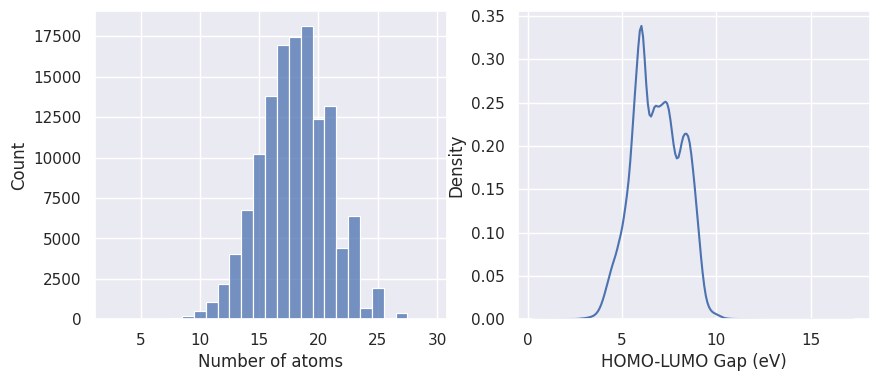

In [9]:
h = plt.figure(figsize=[10, 4])
sns.histplot(data=df, x=df.columns[0], ax=plt.subplot(1, 2, 1), discrete=True)
sns.kdeplot(data=df, x=df.columns[1], ax=plt.subplot(1, 2, 2))
h.show()

## Data Loading and Batching

PyG provides a specialized version of the native PyTorch [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html):

* [torch_geometric.data.DataLoader](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.DataLoader)


The PyG dataloader supports a form of mini-batching which is [described here](https://pytorch-geometric.readthedocs.io/en/latest/notes/batching.html).  Effectively each mini-batch is a concatenation of multiple graphs (molecules in QM9).  Another way to understand this is that each mini-batch is one large graph comprised of multiple disconnected sub-graphs.  The PyG dataloader will generate a `batch` vector that assigns each feature in the mini-batch into a distinct subgraph.  This is useful for message passing networks (such as SchNet) and pooling layers to produce a distinct regression prediction for each molecule. Refer to the following tutorials for additional background:

* [Creating message passing networks](https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html)
* [Global Pooling Layers](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html?highlight=pooling#global-pooling-layers)

This mini-batching approach needs to be adapted for the IPU since the tensor sizes will vary from batch to batch.  This can be observed in the following cell where tensors such as `pos`, `z`, and `batch` all have different sizes between the first two batches of the QM9 dataset. 

In [10]:
loader = DataLoader(dataset, batch_size=4)

it = iter(loader)
next(it), next(it)

(DataBatch(y=[4], pos=[16, 3], z=[16], batch=[16], ptr=[5]),
 DataBatch(y=[4], pos=[21, 3], z=[21], batch=[21], ptr=[5]))

### SchNet Model Architecture

![SchNet Architecture](./static_resources/schnet_arch.png "SchNet Architecture")

The diagram above demonstrates the overall architecture of the SchNet model.  The main inputs to the model are:
* $(Z_1, Z_2, \ldots, Z_n)$ : A vector of atomic numbers which are used as input to the atom-wise embedding layer.
* $(\mathbf{r}_1, \mathbf{r}_2, \ldots, \mathbf{r}_n)$: An `[n, 3]` tensor of atomic positions.

The graph is defined by considering each atom as a node and the edges are defined by:
* placing a sphere of radius $r_\textrm{cut}$ centered on each atom.
* connecting neighbouring atoms that fall within the cutoff sphere with an undirected edge.

The rationale for using this cutoff sphere is to bound the maximum number of atoms that are connected to each other so that the computational cost grows linearly with the number of atoms in the system.

By default the inter-atomic interaction graph will be computed using the `radius_graph` [method](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.pool.radius_graph) in PyTorch Geometric.

### IPU implementation of SchNet

General support for PyTorch on the IPU is accomplished through ahead-of-time compilation with PopTorch. The compiler performs static analysis over the input tensors and the computational graph to optimise the evaluation on the IPU.  To fully leverage these optimisations for the SchNet architecture we need to enforce consistent tensors sizes for all:
* operations used within the model.
* mini-batches of molecular graphs that are inputs to the model.

We first identify that the default interaction graph method using `radius_graph` will by definition create a variable number of edges depending on the geometric structure of the molecule.  This is unfriendly for the ahead-of-time compilation in PopTorch but we can reformulate the interaction graph as a k-nearest neighbours search.  We use the `interaction_graph` argument to the PyTorch Geometric SchNet [implementation](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.models.SchNet) to compute the pairwise interaction graph and interatomic distances.

We can use a simple strategy of appending a padding graph to effectively fill up each mini-batch up to a known maximum possible size.  To accomplish this we need to define non-interacting padding atoms.  These padding atoms are defined as having atomic charge zero.  This ensures there are no artificial interactions introduced between these padding atoms and any real atoms within the mini-batch.

Refer `pyg_schnet_util.py` file for the implementation details that are needed to fully realise an efficient evaulation of the SchNet GNN on the IPU.

As a basic sanity check we can compile the SchNet model with PopTorch and check that we get the same prediction as running the model on the host CPU.

Prepare a mock batch consisting of a single graph using the PyG `Batch.from_data_list` method:

In [11]:
batch = Batch.from_data_list([dataset[0]])
batch

DataBatch(y=[1], pos=[5, 3], z=[5], batch=[5], ptr=[2])

Evaluate the network on the CPU with randomly initialised weights using a fixed random seed

In [12]:
torch.manual_seed(0)
cutoff = 10.0
model = SchNet(cutoff=cutoff)
model.eval()
cpu = model(batch.z, batch.pos, batch.batch)
cpu

tensor([[6.9818]], grad_fn=<ScatterAddBackward0>)

Now evaluate the network on the IPU

In [13]:
with optional_validation(False):
    poptorch.setLogLevel('ERR')
    torch.manual_seed(0)
    knn_graph = KNNInteractionGraph(cutoff=cutoff, k=batch.num_nodes - 1)
    model = SchNet(cutoff=cutoff, interaction_graph=knn_graph)
    model = to_fixed_size(model, batch_size=1)
    options = poptorch.Options()
    options.enableExecutableCaching(executable_cache_dir)
    pop_model = poptorch.inferenceModel(model, options)
    ipu = pop_model(batch.z, batch.pos, batch.batch)

ipu


Graph compilation: 100%|██████████| 100/100 [00:00<00:00]


tensor([[6.9818]])

The predictions must be the same

In [14]:
torch.allclose(cpu, ipu)

True

### Padding
The easiest way to get up and running on the IPU with the QM9 dataset is just to apply padding to the input tensors. This results in every example in the dataset being expanded up to the size of the largest molecule.  This expansion comes at the cost of additional padding nodes and edges.

We use the `PadMolecule` [transform](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html).  This transform modifies each `Data` instance in the dataset to have `max_num_atoms` nodes.

The `PadMolecule` transform is defined in `pyg_schnet_util.py` along with a function that builds an entire data pre-processing pipeline.

We can explore how the pipeline converts an input molecule into one that is padded up to the maximum graph size in the dataset.  An experiment to try is to change the value of `i` to explore the data.

In [15]:
data = dataset[0]
batch = Batch.from_data_list([data, padding_graph(32 - data.num_nodes)])
batch

DataBatch(y=[2], pos=[32, 3], z=[32], batch=[32], ptr=[3])

The next sanity check is to verify that the padding hasn't introduced any numerical artifacts in the resulting prediction.  Once again we prepare a mock batch consisting of a single graph but apply the transform we made earlier by calling `create_transform`

Evaluate the network on the host with randomly initialised weights using a fixed random seed and the padded batch

In [16]:
torch.manual_seed(0)
model = SchNet(cutoff=cutoff)
model.eval()
padded_cpu = model(batch.z, batch.pos, batch.batch)
padded_cpu

tensor([[6.9818],
        [0.0000]], grad_fn=<ScatterAddBackward0>)

The result should be the same as the one we calculated earlier without any padding

In [17]:
torch.allclose(cpu, padded_cpu[0])

True

Now evaluate the same test using the IPU

In [18]:
with optional_validation(False):
    torch.manual_seed(0)
    knn_graph = KNNInteractionGraph(cutoff=cutoff, k=batch.num_nodes - 1)
    model = SchNet(cutoff=cutoff, interaction_graph=knn_graph)
    model = to_fixed_size(model, batch_size=2)
    options = poptorch.Options()
    options.enableExecutableCaching(executable_cache_dir)
    pop_model = poptorch.inferenceModel(model, options)
    padded_ipu = pop_model(batch.z, batch.pos, batch.batch)

padded_ipu

Graph compilation: 100%|██████████| 100/100 [00:00<00:00]


tensor([[6.9818],
        [0.0000]])

The predictions must be the same as calculated earlier without any paddding

In [19]:
torch.allclose(ipu, padded_ipu[0])

True

### Efficient data loading for the IPU

PopTorch provides a custom data loader implementation that can be used for efficient data batching and transfers between the host and IPU device.  Please refer to the following resources for additional background:
* PopTorch documentation [Efficient data batching](https://docs.graphcore.ai/projects/poptorch-user-guide/en/latest/batching.html#efficient-data-batching)
* PopTorch tutorial: [Efficient data loading](https://github.com/graphcore/tutorials/tree/sdk-release-2.5/tutorials/pytorch/tut2_efficient_data_loading)

Below we define a custom collater that leverages the PyG graph batching for the IPU.  This collator ensures that advanced batching scenarios such as data-parallel training, multiple device iterations, and gradient accumulation are handled correctly. These concepts are all covered in much greater detail in the resources above.

Next we define a helper function that creates an instance of `poptorch.DataLoader` that uses the collator defined above.

### Putting everything together to train SchNet

We can now train SchNet on the IPU using all of the concepts introduced earlier.  To start with we shuffle and split the dataset into testing, validation, and training splits.

In [20]:
num_test = 10000
num_val = 10000
torch.manual_seed(0)
dataset.transform = prepare_data
dataset = dataset.shuffle()
test_dataset = dataset[:num_test]
val_dataset = dataset[num_test:num_test + num_val]
train_dataset = dataset[num_test + num_val:]

print(f"Number of test molecules: {len(test_dataset)}\n"
      f"Number of validation molecules: {len(val_dataset)}\n"
      f"Number of training molecules: {len(train_dataset)}")


Number of test molecules: 10000
Number of validation molecules: 10000
Number of training molecules: 110831


Setup the hyperparameters for training the network.  These can be changed to explore the different trade-offs they offer in terms of training accuracy and performance throughput.

In [21]:
batch_size = 16
replication_factor = num_ipus
device_iterations = 16
gradient_accumulation = 16 // num_ipus
num_dataloader_workers = 4
learning_rate = 1e-4
num_epochs = 20

Create the `poptorch.Options` object with the right parameters setup

In [22]:
options = poptorch.Options()
options.enableExecutableCaching(executable_cache_dir)
options.outputMode(poptorch.OutputMode.All)
options.deviceIterations(device_iterations)
options.replicationFactor(replication_factor)
options.Training.gradientAccumulation(gradient_accumulation);


Create the SchNet model and pre-compile for the IPU

In [23]:
train_loader = create_dataloader(train_dataset,
                                 options,
                                 batch_size,
                                 shuffle=True,
                                 num_workers=num_dataloader_workers)

In [24]:
torch.manual_seed(0)
knn_graph = KNNInteractionGraph(cutoff=cutoff, k=32)
model = SchNet(cutoff=cutoff, interaction_graph=knn_graph)
model.train()
model = TrainingModule(model, batch_size=batch_size)

In [25]:
optimizer = poptorch.optim.AdamW(model.parameters(), lr=learning_rate)
training_model = poptorch.trainingModel(model, options, optimizer)

In [26]:
data = next(iter(train_loader))

In [27]:
with optional_validation(False):
    training_model.compile(*data)

Graph compilation: 100%|██████████| 100/100 [00:01<00:00]


Train the model with the selected hyperparameters and log the mean loss from each batch.

In [28]:
train = []

for epoch in range(num_epochs):
    bar = tqdm(train_loader)
    for i, data in enumerate(bar):
        _, mini_batch_loss = training_model(*data)
        loss = float(mini_batch_loss.mean())
        train.append({'epoch': epoch, 'step': i, 'loss': loss})
        bar.set_description(f"Epoch {epoch} loss: {loss:0.6f}")


Epoch 19 loss: 0.140594: 100%|██████████| 28/28 [00:03<00:00,  7.41it/s]


Plot the mean of the loss

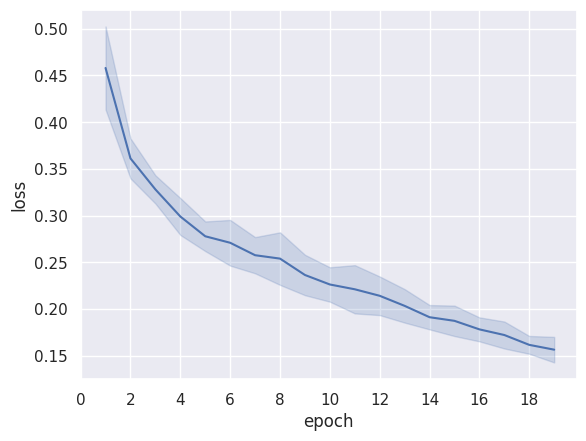

In [29]:
df = pd.DataFrame(train)
g = sns.lineplot(data=df[df.epoch > 0], x='epoch', y='loss', errorbar='sd')
g.set_xticks(range(0, 20, 2))
g.figure.show()

## Follow up
The training loss looks like it is descreasing nicely over a relatively small number of epochs, try measuring the validation accuracy.  The following publications demonstrate using IPUs to train SchNet

* [Reducing Down(stream)time: Pretraining Molecular GNNs using Heterogeneous AI Accelerators](https://arxiv.org/abs/2211.04598)
* [Extreme Acceleration of Graph Neural Network-based Prediction Models for Quantum Chemistry](https://arxiv.org/abs/2211.13853)

The dataset used in these papers is available in PyG as [HydroNet](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.HydroNet).
